In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import math, json, os, sys

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.optimizers import Adam, SGD
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

In [3]:
keras.backend.backend()

'tensorflow'

In [4]:
keras.backend.image_dim_ordering()

'tf'

In [5]:
keras.__version__

'2.2.2'

In [6]:
DATA_DIR = 'C:\\Users\\rutuj\\Desktop\\Fall18\\ML\\Classification\\10-monkey-species\\data'
TRAIN_DIR = os.path.join(DATA_DIR, 'training')
VALID_DIR = os.path.join(DATA_DIR, 'validation')
SIZE = (224, 224)
BATCH_SIZE = 32

In [7]:
num_train_samples = sum([len(files) for r, d, files in os.walk(TRAIN_DIR)])
num_valid_samples = sum([len(files) for r, d, files in os.walk(VALID_DIR)])

num_train_steps = math.floor(num_train_samples/BATCH_SIZE)
num_valid_steps = math.floor(num_valid_samples/BATCH_SIZE)

In [8]:
print(num_train_samples)
print(num_valid_samples)
print(num_train_steps)
print(num_valid_steps)

1098
272
34
8


### Keras data generators 

In [9]:
train_datagen = ImageDataGenerator(
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 10,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    preprocessing_function = preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size = BATCH_SIZE,
    target_size = SIZE,
    class_mode = 'categorical',
    shuffle = True)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    VALID_DIR,
    batch_size = BATCH_SIZE,
    target_size = SIZE,
    class_mode = 'categorical',
    shuffle = True)

Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


### Using weights of ResNet trained on imagenet

In [10]:
conv_base = ResNet50(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

C:\Users\rutuj\Anaconda3\envs\deepmlenv\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


NOTE: Keras removed the Average pooling layer from ResNet50, 
so we have to add a GlobalAveragePooling Layer 
before we attach a fully connected network at the tail.

In [11]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)

# attaching fully connected layers at the tail.
# final dense layer has 10 neurons as we have 10 classes.
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(10, activation='softmax')(x)
model = Model(inputs = conv_base.input, outputs = predictions)

In [12]:
#optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

### Model Training

NOTE: TensorBoard Callbacks don't work with fit_generator?

UPDATE: Callbacks don't work on Windows. Execution leads to 'Entry Point Not Found' error because some .so files couldn't be found. Some problem with linking .so files from contrib folder.
More info here - https://github.com/tensorflow/tensorflow/issues/21054

In [13]:
import time
#tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
#tensorboard.set_model(model)
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch = num_train_steps,
                              epochs = 50,
                              validation_steps = num_valid_steps,
                              validation_data = validation_generator,
                              #callbacks = [tensorboard]
                             )

Epoch 1/50
34/34 [==============================] - 54s 2s/step - loss: 2.2637 - acc: 0.2134 - val_loss: 1.6454 - val_acc: 0.4559
Epoch 2/50
34/34 [==============================] - 59s 2s/step - loss: 1.5442 - acc: 0.5655 - val_loss: 0.9951 - val_acc: 0.7243
Epoch 3/50
34/34 [==============================] - 58s 2s/step - loss: 1.0606 - acc: 0.7398 - val_loss: 0.6957 - val_acc: 0.7721
Epoch 4/50
34/34 [==============================] - 55s 2s/step - loss: 0.7913 - acc: 0.8065 - val_loss: 0.5181 - val_acc: 0.8456
Epoch 5/50
34/34 [==============================] - 55s 2s/step - loss: 0.6160 - acc: 0.8506 - val_loss: 0.3663 - val_acc: 0.9007
Epoch 6/50
34/34 [==============================] - 59s 2s/step - loss: 0.5109 - acc: 0.8768 - val_loss: 0.3975 - val_acc: 0.8640
Epoch 7/50
34/34 [==============================] - 59s 2s/step - loss: 0.4312 - acc: 0.8943 - val_loss: 0.3383 - val_acc: 0.9118
Epoch 8/50
34/34 [==============================] - 56s 2s/step - loss: 0.4074 - acc: 0.89

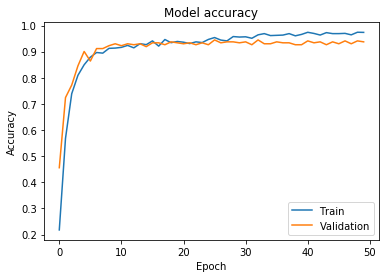

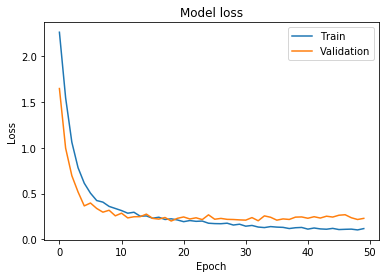

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Save and load the fine-tuned model

In [15]:
# architecture and weights to HDF5
#model.save('models/resnet-adam/model.h5')

# architecture to JSON, weights to HDF5
#model.save_weights('models/resnet-adam/weights.h5')
#with open('models/resnet-adam/architecture.json', 'w') as f:
        #f.write(model.to_json())

In [16]:
# architecture and weights from HDF5
#model = load_model('models/resnet-adam/model.h5')

# architecture from JSON, weights from HDF5
#with open('models/resnet-adam/architecture.json') as f:
    #model = model_from_json(f.read())
#model.load_weights('models/resnet-adam/weights.h5')

### Predictions on test images

In [25]:
test_img_paths = ["data/test/n0018.jpg",
                        "data/test/n018.jpg",
                        "data/test/n4016.jpg",
                        "data/test/n4017.jpg",
                        "data/test/dummy1.jpg",
                        "data/test/n0dummy.jpg",
                        "data/test/n6dummy.jpg"
                       ]
img_list = [Image.open(img_path) for img_path in test_img_paths]

In [26]:
# Preprocess the test images to match resnet specifications
test_batch = np.stack([preprocess_input(np.array(img.resize((224,224))))
                             for img in img_list])

In [27]:
pred_probs = model.predict(test_batch)

In [28]:
pred_probs[0]

array([9.9999678e-01, 1.9742883e-09, 6.0577044e-08, 5.2743495e-12,
       4.3429004e-08, 3.6593985e-08, 2.1917308e-11, 2.6196161e-09,
       3.3101384e-07, 2.7831486e-06], dtype=float32)

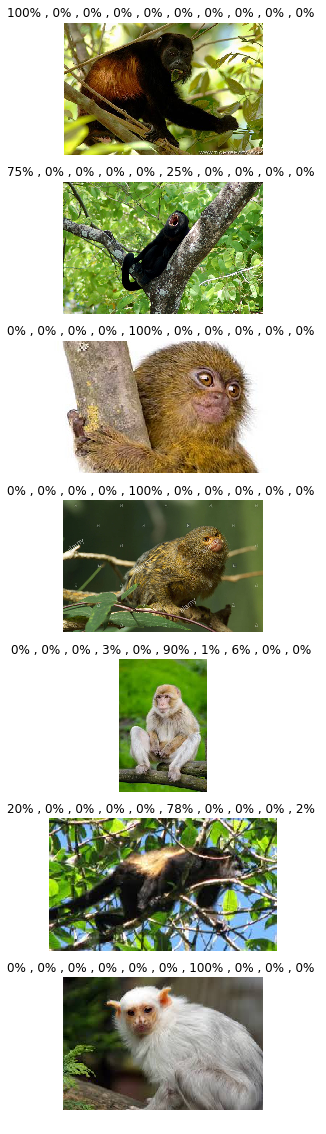

In [29]:
fig, axs = plt.subplots(len(img_list), 1, figsize=(20, 20))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% , {:.0f}% , {:.0f}% , {:.0f}% , {:.0f}% , {:.0f}% , {:.0f}% , {:.0f}% , {:.0f}% , {:.0f}% "
                 .format(100*pred_probs[i,0], 
                         100*pred_probs[i,1],
                         100*pred_probs[i,2],
                         100*pred_probs[i,3],
                         100*pred_probs[i,4],
                         100*pred_probs[i,5],
                         100*pred_probs[i,6],
                         100*pred_probs[i,7],
                         100*pred_probs[i,8],
                         100*pred_probs[i,9]
                        ))
    ax.imshow(img)